In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

import random

In [82]:
WIDTH=150
HEIGHT=150
IMAGE_SIZE=(WIDTH, HEIGHT)
IMAGE_CHANNELS=3
batch_size = 50

In [4]:
pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 604.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 11.5 MB/s eta 0:00:00


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import py7zr

# with ZipFile('../content/drive/MyDrive/GlassMetal.zip', 'r') as zip:
#     zip.extractall()


with py7zr.SevenZipFile('../content/drive/MyDrive/UnSortedWaste.7z', mode='r') as z:
     z.extractall()


In [8]:
path =  "../content/UnSortedWaste"
train_dir = os.path.join(path, "train")
validation_dir = os.path.join(path, "validation")
filenames = os.listdir(path)

In [83]:
#delete dirs
shutil.rmtree( train_dir )
shutil.rmtree( validation_dir )



In [84]:
labels = ["cardboard", "glass", "metal", "plastic", "trash", "paper"]

os.makedirs(train_dir)
os.makedirs(validation_dir)

for label in labels:
  os.makedirs(os.path.join(train_dir, label))
  os.makedirs(os.path.join(validation_dir, label))


In [85]:
df = pd.DataFrame(data=filenames, columns=['file_name'])
total_train, total_validate = 0, 0

df['label'] = df['file_name'].apply(lambda x: "cardboard" if x[:3]=='car'
                                    else 'glass' if x[:3]=='gla'
                                    else "metal" if x[:3]=='met'
                                    else "paper" if x[:3]=='pap'
                                    else "plastic" if x[:3]=="pla"
                                    else "trash")


for label in df['label'].unique():
    files = df[df['label']==label]['file_name']
    train = np.random.choice(files, size=int(len(files)*0.8))
    test = [_ for _ in files if not (_ in train)]
    print(label, len(files), len(train), len(test))
    total_train += len(train)
    total_validate += len(test)

    for file in train:
      shutil.copyfile(os.path.join(path, file),
                     os.path.join(train_dir, label, file))

    for file in test:
      shutil.copyfile(os.path.join(path, file),
                     os.path.join(validation_dir, label, file))


glass 501 400 234
cardboard 403 322 168
plastic 482 385 223
paper 594 475 267
metal 410 328 176
trash 137 109 61


In [92]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (2,2), activation='relu', input_shape=(WIDTH, HEIGHT, IMAGE_CHANNELS)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(16, (2,2), activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(32, (2,2), activation='relu'),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 149, 149, 8)       104       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 74, 74, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 73, 73, 16)        528       
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 36, 36, 16)       0         
 g2D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 36, 36, 16)        0         
                                                                 
 conv2d_54 (Conv2D)          (None, 35, 35, 32)      

In [93]:

from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='mse',
              metrics = ['accuracy'])

In [94]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( rescale = 1.0/255. ,
                                   rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


In [95]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=IMAGE_SIZE )

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=batch_size,
                                                         class_mode  = 'categorical',
                                                         target_size = IMAGE_SIZE)

Found 1398 images belonging to 6 classes.
Found 1129 images belonging to 6 classes.


In [96]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
earlystop = EarlyStopping(patience=6,restore_best_weights=True)


In [97]:
history = model.fit(
            train_generator,
            epochs=60,
            validation_data=validation_generator,
            verbose=2,
            callbacks=[earlystop]
            )

Epoch 1/60
28/28 - 14s - loss: 0.1614 - accuracy: 0.2411 - val_loss: 0.1383 - val_accuracy: 0.2834 - 14s/epoch - 487ms/step
Epoch 2/60
28/28 - 11s - loss: 0.1248 - accuracy: 0.3712 - val_loss: 0.1377 - val_accuracy: 0.3561 - 11s/epoch - 397ms/step
Epoch 3/60
28/28 - 10s - loss: 0.1169 - accuracy: 0.4349 - val_loss: 0.1367 - val_accuracy: 0.3410 - 10s/epoch - 344ms/step
Epoch 4/60
28/28 - 11s - loss: 0.1144 - accuracy: 0.4464 - val_loss: 0.1365 - val_accuracy: 0.3738 - 11s/epoch - 387ms/step
Epoch 5/60
28/28 - 11s - loss: 0.1096 - accuracy: 0.4750 - val_loss: 0.1346 - val_accuracy: 0.3968 - 11s/epoch - 401ms/step
Epoch 6/60
28/28 - 11s - loss: 0.1077 - accuracy: 0.4835 - val_loss: 0.1339 - val_accuracy: 0.4305 - 11s/epoch - 400ms/step
Epoch 7/60
28/28 - 11s - loss: 0.1049 - accuracy: 0.5043 - val_loss: 0.1338 - val_accuracy: 0.3818 - 11s/epoch - 378ms/step
Epoch 8/60
28/28 - 12s - loss: 0.1042 - accuracy: 0.5114 - val_loss: 0.1313 - val_accuracy: 0.4322 - 12s/epoch - 413ms/step
Epoch 9/

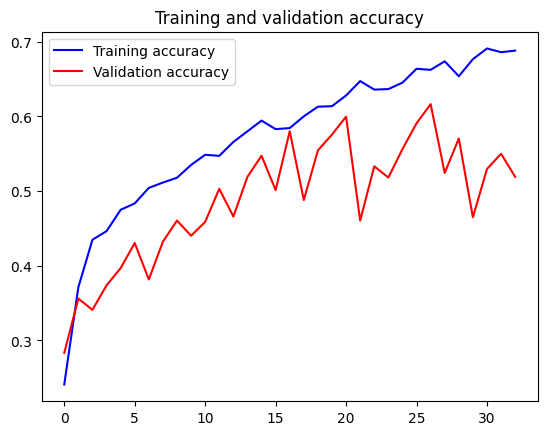

<Figure size 640x480 with 0 Axes>

In [98]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

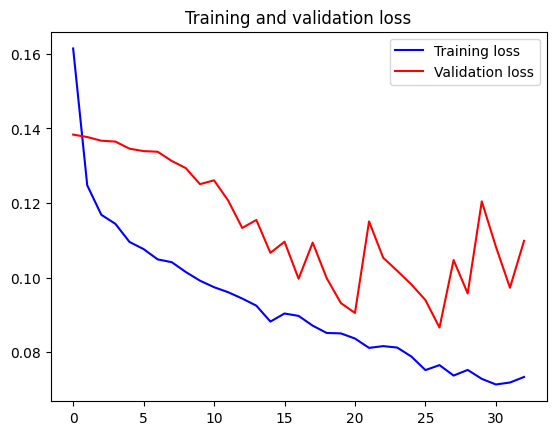

<Figure size 640x480 with 0 Axes>

In [99]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
model = tf.keras.models.Sequential([
        #    filters, strides
        tf.keras.layers.Conv2D(16, (2, 2), activation='relu', input_shape=(WIDTH, HEIGHT, IMAGE_CHANNELS)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(64, (2, 2), activation='relu',padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(128, (2, 2), activation='relu',padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(256, (2, 2), activation='relu',padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),


        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(6, activation='softmax')# 6 because we have 6 classes
])